In [14]:
import os
import sys

import ipywidgets as widgets
from IPython.display import display
from IPython.display import update_display
from IPython.display import display_pretty
import psycopg2

%matplotlib notebook
import matplotlib.pyplot as plt

from gpt_api import set_openai_key, GPT, Example

In [13]:
# Load credentials from environment. 
POSTGRES_ADDRESS = os.environ.get('POSTGRES_ADDRESS')
POSTGRES_PORT = os.environ.get('POSTGRES_PORT')
POSTGRES_USERNAME = os.environ.get('POSTGRES_USERNAME')
POSTGRES_PASSWORD = os.environ.get('POSTGRES_PASSWORD')
POSTGRES_DBNAME = os.environ.get('POSTGRES_DBNAME')
OPENAI_KEY = os.environ.get('OPENAI_KEY')


In [4]:
# Create connection and cursor.
conn = psycopg2.connect(host=POSTGRES_ADDRESS,
                  database=POSTGRES_DBNAME,
                  user=POSTGRES_USERNAME,
                  password=POSTGRES_PASSWORD,
                  port=POSTGRES_PORT)
cur = conn.cursor()

In [5]:
# Set OpenAI key.
set_openai_key(OPENAI_KEY)

In [17]:
# Construct GPT-3-instruct instance, add instruction and examples
gpt = GPT(engine="davinci-instruct-beta",
          temperature=0.3,
          max_tokens=200)
gpt.add_instruction("Given an input question, respond with syntactically correct PostgreSQL."
                    " Only use the table called 'income'. The 'income' table has columns:"
                    " symbol (varchar(5)), fillingDate (timestamp), revenue (bigint), grossProfit (bigint),"
                    " costAndExpenses (bigint), and ebitda (bigint)")
                    #" symbol (varchar(5)), fillingDate (timestamp), revenue (bigint), grossProfit (bigint),"
                    #" researchAndDevelopmentExpenses (bigint), generalAndAdministrativeExpenses (bigint),"
                    #" sellingAndMarketingExpenses (bigint), otherExpenses (bigint), operatingExpenses (bigint),"
                    #" costAndExpenses (bigint), interestExpense (bigint), ebitda (bigint), operatingIncome (bigint),"
                    #" incomeBeforeTax (bigint), and incomeTaxExpense (bigint)")

gpt.add_example(Example("What are the columns from income table?", 
                        "SELECT symbol, fillingDate, revenue, grossProfit, costAndExpenses, ebitda FROM income"))
gpt.add_example(Example("How many companies have a filing date in the past 90 days?", 
                        "SELECT COUNT(*) FROM income WHERE fillingDate >= now() - interval '90 days'"))
gpt.add_example(Example("When did company with symbol AAPL file its financial statement?", 
                        "SELECT fillingDate FROM income WHERE symbol = 'AAPL'"))
gpt.add_example(Example("How much revenue did AAPL have in the last 2 years?", 
                        "SELECT SUM(revenue) FROM income WHERE symbol = 'AAPL'"
                        " AND fillingDate >= now() - interval '2 years'"))
gpt.add_example(Example("What was the maximum revenue GOOGL had in the last 5 years?", 
                        "SELECT MAX(revenue) from income WHERE symbol = 'GOOGL'"
                        " AND fillingDate >= now() - interval '5 years'"))
gpt.add_example(Example("What were the top 5 companies with the highest EBITDA?", 
                        "SELECT ebitda, symbol from income ORDER BY ebitda desc LIMIT 5"))
gpt.add_example(Example("What is the EBITDA of MSFT?", 
                        "SELECT ebitda from income WHERE symbol = 'MSFT'"
                        " AND fillingDate >= now() - interval '1 year'"))
gpt.add_example(Example("Plot the revenue over time of AAPL over the last 8 years", 
                        "SELECT fillingDate, revenue FROM income WHERE symbol = 'AAPL'"
                        " AND fillingDate >= now() - interval '8 years'"))

In [24]:
# Define display flow for GPT question input
def on_button_clicked(b):
    def sql_button_clicked(b):
        conn.commit()
        cur.execute(query)
        result = cur.fetchall()
        if len(result) == 1:
            display(result[0][0])
        elif len(result) >= 1 and len(result[0]) == 2:
            # Display graph data
            %matplotlib inline
            x, y = zip(*result)
            plt.plot(x, y)
        else:
            display(result)
        
    print ('\033[1mInput:\033[0m ' + inp.value)
    output = gpt.submit_request(inp.value)
    result = output['choices'][0].text
    query = result.split('output:')[1]
    print ('\033[1mGPT-3 Response:\033[0m ' + query)
    button2 = widgets.Button(description="Run SQL")
    button2.on_click(sql_button_clicked)
    display(button2)

# Run the GPT-to-Postgres widget

Translate English-language questions into SQL queries and execute queries on the "income" table of financial data.

Instruction: Given an input question, respond with syntactically correct PostgreSQL.


Input: Plot the ebitda over time of MSFT over the last 5 years
GPT-3 Response:  SELECT fillingDate, ebitda FROM income WHERE symbol = 'MSFT' AND fillingDate >= now() - interval '5 years'




Button(description='Run SQL', style=ButtonStyle())

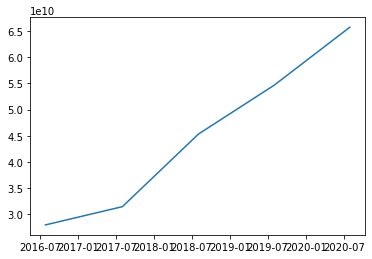

In [26]:
# Display UI to give GPT-3 prompt and run and display resulting SQL
inp = widgets.Text(description='Ask GPT-3:')
button1 = widgets.Button(description="Get GPT-3 Response")
Box = widgets.HBox([inp, button1])
print ('\033[1mInstruction:\033[0m ' + "Given an input question, respond with syntactically correct PostgreSQL.")
button1.on_click(on_button_clicked)
display(Box)